# Three Types of Logistic Regression

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline

## Aggregating and Preprocessing Data for Analysis

In [2]:
studentInfo = pd.read_csv('../__DATA__/VLEData/studentInfo.csv')
courses = pd.read_csv('../__DATA__/VLEData/courses.csv')
assessments = pd.read_csv('../__DATA__/VLEData/assessments.csv')
studentAssess = pd.read_csv('../__DATA__/VLEData/studentAssessment.csv')
studentReg = pd.read_csv('../__DATA__/VLEData/studentRegistration.csv')
studentVle = pd.read_csv('../__DATA__/VLEData/studentVle.csv')

In [3]:
###Compiling all CompVLE code into one cell.

#Combining Student Test performance with test information
AssessCompo = pd.merge(studentAssess, assessments, how="left", on=['id_assessment'])

#Converting scores to be weight adjusted to reflect the points contributed to overall class score
AssessCompo['wtadj_score'] = AssessCompo['score'] * AssessCompo['weight']/100

#Aggregating assessment scores for each individual in each class
AssessCompo1 = AssessCompo.groupby(['id_student','code_module','code_presentation']).sum()[['weight','wtadj_score']].reset_index()

#Dropping multiple test versions from the assessments dataframe so they don't aggregate into a 
#total score weight that deflates the students score (some classses had multiple test versions for one test) 
assessment2 = assessments.drop([62,72]).groupby(['code_module','code_presentation']).sum()['weight'].reset_index().rename(columns={'weight':'tot_weight'})

#Creating feature 'final_score' which is the percentage of all possible points in the course the students achieved
AssessCompo2 = pd.merge(AssessCompo1, assessment2, how='left', on=['code_module','code_presentation'])
AssessCompo2['final_score'] = round(100*AssessCompo2['wtadj_score']/AssessCompo2['tot_weight'], 2)

#Merging student assessment data with student demographic data
StudentComp = pd.merge(studentInfo, AssessCompo2, how='left', on=['code_module','code_presentation','id_student'])

#Aggregating clicks by individuals students in each class, and merging this aggregation with the rest of the info
clicks = studentVle.groupby(['code_module','code_presentation','id_student']).sum()['sum_click'].reset_index()
StudentComp1 = pd.merge(StudentComp, clicks, how='left', on=['code_module','code_presentation','id_student'])

#Merging student registration information with the master dataframe
VleFinalDF = pd.merge(StudentComp1, studentReg, how='left', on=['id_student','code_module','code_presentation'])

#Use the below code to see all of the colums included in the 
#cols = list(VleFinalDF.columns.values)

#Reording the columns in the final dataframe
cols = ['code_module',
 'code_presentation',
 'id_student',
 'gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'num_of_prev_attempts',
 'studied_credits',
 'disability',
 'date_registration',
 'date_unregistration',
 'sum_click',
 'final_score',
 'final_result']

#This is the final data frame with raw information.
CompVle = VleFinalDF[cols]
display(CompVle.head())
print(CompVle.shape)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,final_score,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,-159.0,NaN,934.0,41.20,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,-53.0,NaN,1435.0,32.70,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,-92.0,12.0,281.0,NaN,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,-52.0,NaN,2158.0,38.15,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,-176.0,NaN,1034.0,27.50,Pass


(32593, 16)


In [4]:
### Aggregated Code for Preprocessing

CompVlePP = pd.get_dummies(CompVle['code_module'])
CompVlePP = pd.concat([CompVlePP, pd.get_dummies(CompVle['code_presentation'])], axis = 1)
#CompVlePP = pd.concat([CompVlePP, pd.get_dummies(features['mod_presentation'])], axis = 1)
CompVlePP = pd.concat([CompVlePP, pd.get_dummies(CompVle['region'])], axis = 1)
CompVlePP = pd.concat([CompVlePP, pd.get_dummies(CompVle['gender'])], axis = 1)
CompVlePP = pd.concat([CompVlePP, pd.get_dummies(CompVle['highest_education'])], axis = 1)
#CompVlePP = pd.concat([CompVlePP, CompVle['sum_click']], axis = 1)

##Create a dataframe 'features' containing another preprocessing step for other features
features = pd.DataFrame(np.log(CompVle['sum_click'].fillna(0) + 1))
features = features.rename(columns={'sum_click':'log_sum_click'})
features['imd_band'] = CompVle['imd_band']
features['imd_band'] = features['imd_band'].replace({ '90-100%': 95 , '20-30%': 25 , '30-40%': 35 , '50-60%': 55 , '80-90%': 85, '70-80%': 75,
       '60-70%': 65, '40-50%' : 45 , '10-20' : 15, '0-10%': 5})
features['age_band'] = CompVle['age_band']
features['age_band'] = features['age_band'].replace({'55<=': 2 , '35-55' : 1 , '0-35' : 0})

##Preprocessing and Scaling log sum click
#float_array = features['log_sum_click'].values.astype(float).reshape(-1, 1)
#min_max_scaler = preprocessing.MinMaxScaler()
#scaled_array = min_max_scaler.fit_transform(float_array)
#CompVlePP['clicks_scaled'] = pd.DataFrame(scaled_array)

##Preprocessing Clicks to be powertransformed
clicks = (CompVle['sum_click'].fillna(0)).values.reshape(-1,1)
click_trans = preprocessing.power_transform(clicks, method = 'yeo-johnson')
clicktdf = pd.DataFrame(click_trans)
CompVlePP['clicks_trans'] = clicktdf

##Preprocessing and Scaling log imd_band
float_array = features['imd_band'].values.astype(float).reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(float_array)
CompVlePP['imd_band'] = pd.DataFrame(scaled_array)

CompVlePP['age_band'] = features['age_band']

##Binarizing the number of attempts for the course
X = CompVle['num_of_prev_attempts'].values.reshape(-1,1)
Binarize = preprocessing.Binarizer(0)
binary_array = Binarize.fit_transform(X)
CompVlePP['reattempted'] = pd.DataFrame(binary_array)

##Rescaling the studied_credits column
float_array = CompVle['studied_credits'].values.astype(float).reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(float_array)
CompVlePP['studied_credits'] = pd.DataFrame(scaled_array)

##Binarizing Disability
binary_disability = CompVle['disability'].replace({'Y':1,'N':0})
CompVlePP['disability'] = pd.DataFrame(binary_disability)

##Adding the Final Score Outcome Variable to the dataframe
CompVlePP = pd.concat([CompVlePP, CompVle['final_score']], axis = 1)

##Filling in missing values
CompVlePP['final_score'] = CompVlePP['final_score'].fillna(0)
CompVlePP['imd_band'] = CompVlePP['imd_band'].fillna(CompVlePP['imd_band'].mean())
CompVlePP['clicks_trans'] = CompVlePP['clicks_trans'].fillna(CompVlePP['clicks_trans'].min())
#CompVlePP['sum_click'] = CompVlePP['sum_click'].fillna(0)

##Adding and Binarizing Final Result feature (Pass/No Pass)
CompVlePP['final_result'] = CompVle['final_result']
CompVlePP.loc[CompVlePP['final_result'] == 'Pass', 'final_result'] = 1
CompVlePP.loc[CompVlePP['final_result'] == 'Distinction', 'final_result'] = 1
CompVlePP.loc[CompVlePP['final_result'] == 'Withdrawn', 'final_result'] = 0
CompVlePP.loc[CompVlePP['final_result'] == 'Fail', 'final_result'] = 0

display(CompVlePP.head())
CompVlePP.columns

,AAA,BBB,CCC,DDD,EEE,FFF,GGG,2013B,2013J,2014B,...,No Formal quals,Post Graduate Qualification,clicks_trans,imd_band,age_band,reattempted,studied_credits,disability,final_score,final_result
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0.338121,1.000000,2,0,0.336,0,41.20,1
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0.624849,0.222222,1,0,0.048,0,32.70,1
2,1,0,0,0,0,0,0,0,1,0,...,0,0,-0.323779,0.333333,1,0,0.048,1,0.00,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0.925874,0.555556,1,0,0.048,0,38.15,1
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0.403401,0.555556,0,0,0.048,0,27.50,1


Index(['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG', '2013B', '2013J',
       '2014B', '2014J', 'East Anglian Region', 'East Midlands Region',
       'Ireland', 'London Region', 'North Region', 'North Western Region',
       'Scotland', 'South East Region', 'South Region', 'South West Region',
       'Wales', 'West Midlands Region', 'Yorkshire Region', 'F', 'M',
       'A Level or Equivalent', 'HE Qualification', 'Lower Than A Level',
       'No Formal quals', 'Post Graduate Qualification', 'clicks_trans',
       'imd_band', 'age_band', 'reattempted', 'studied_credits', 'disability',
       'final_score', 'final_result'],
      dtype='object')

In [6]:
#Dropping Unhelpful features
CompVlePP2 = CompVlePP[['2013B', '2013J',
       '2014B', '2014J', 'London Region', 'F', 'M',
       'A Level or Equivalent', 'HE Qualification', 'Lower Than A Level',
       'No Formal quals', 'Post Graduate Qualification', 'clicks_trans',
       'imd_band', 'age_band', 'reattempted', 'studied_credits', 'disability',
       'final_score', 'final_result']]

## Vanilla Logistic Regression

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
from sklearn.model_selection import cross_val_score

lr = linear_model.LogisticRegression(C=1e9)
X = CompVlePP2.iloc[:,:18]
Y = CompVlePP2['final_result']
fit = lr.fit(X,Y)
print(fit.score(X,Y))

cvs = cross_val_score(lr, X, Y, cv=10)
print(cvs.mean())
print(cvs.std())
LogCoefs = fit.coef_

0.8091307949559722
0.7872260781480177
0.04510777747028193


In [26]:
lr = linear_model.LogisticRegression(penalty='l1')
X = CompVlePP2.iloc[:,:18]
Y = CompVlePP2['final_result']
fit = lr.fit(X,Y)
print(fit.score(X,Y))

cvs = cross_val_score(lr, X, Y, cv=10)
print(cvs.mean())
print(cvs.std())
LassoLogCoefs = fit.coef_

0.8089160249133249
0.7871033505186886
0.04503323571279942


In [27]:
lr = linear_model.LogisticRegression(penalty='l2')
X = CompVlePP2.iloc[:,:18]
Y = CompVlePP2['final_result']
fit = lr.fit(X,Y)
print(fit.score(X,Y))

cvs = cross_val_score(lr, X, Y, cv=10)
print(cvs.mean())
print(cvs.std())
RidgeLogCoefs = fit.coef_

0.8092228392599637
0.7872259180976324
0.04494482067883079


In [40]:
print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')
comparecoefs = pd.DataFrame()
comparecoefs['Log'] = LogCoefs[0]
comparecoefs['LassoLog'] = LassoLogCoefs[0]
comparecoefs['RidgeLog'] = RidgeLogCoefs[0]
comparecoefs['Coefs'] = X.columns
comparecoefs


Parameter Estimates for the same predictors for the small modeland large model:


,Log,LassoLog,RidgeLog,Coefs
0,-0.438951,-0.546807,-0.442857,2013B
1,0.196349,0.086485,0.193967,2013J
2,0.034744,-0.073079,0.034077,2014B
3,0.109995,0.000360,0.108167,2014J
4,-0.082980,-0.081170,-0.084476,London Region
5,0.416654,0.559566,0.411719,F
6,-0.514516,-0.369552,-0.518366,M
7,0.207653,0.069618,0.203901,A Level or Equivalent
8,0.138373,0.000000,0.134222,HE Qualification
9,-0.333221,-0.469609,-0.334102,Lower Than A Level


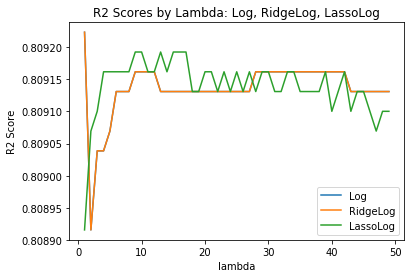

In [61]:
X = CompVlePP2.iloc[:,:18]
Y = CompVlePP2['final_result']

scores_ridg = np.zeros([1,2])
scores_lass = np.zeros([1,2])
scores_log = np.zeros([1,2])

#Fitting and Scoring Lasso and Ridge Regression Models for a range of lambda values
for lambd in range(1, 50, 1):
    lr = linear_model.LogisticRegression(C=lambd)
    lrfit = lr.fit(X,Y)
    scores_log = np.row_stack((
        scores_log,
        np.append(lrfit.score(X, Y),[lambd])))

    lr1 = linear_model.LogisticRegression(penalty='l1',C=lambd)
    lr1fit = lr1.fit(X,Y)
    scores_lass = np.row_stack((
        scores_lass,
        np.append(lr1fit.score(X, Y),[lambd])))
    
    lr2 = linear_model.LogisticRegression(penalty='l2',C=lambd)
    lr2fit = lr2.fit(X,Y)
    scores_ridg = np.row_stack((
        scores_ridg,
        np.append(lr2fit.score(X, Y),[lambd])))
    
# Make the data pretty.
scores_log = np.delete(scores_log, (0), axis=0)
scores_log_df = pd.DataFrame(
    scores_log,
    columns=['R2_score_log','lambda'])

scores_lass = np.delete(scores_lass, (0), axis=0)
scores_lass_df = pd.DataFrame(
    scores_lass,
    columns=['R2_score_lass','lambda'])

scores_ridg = np.delete(scores_ridg, (0), axis=0)
scores_ridg_df = pd.DataFrame(
    scores_ridg,
    columns=['R2_score_ridg','lambda'])

#merging the scores to one dataframe
scores_df = scores_log_df.merge(scores_lass_df, on='lambda')
scores_df = scores_df.merge(scores_ridg_df, on='lambda')
scores_df.sort_values(by='lambda', ascending = True)

# Plot the regression score curves
plt.plot(scores_df['lambda'], scores_df['R2_score_log'], label='Log')
plt.plot(scores_df['lambda'], scores_df['R2_score_ridg'], label='RidgeLog')
plt.plot(scores_df['lambda'], scores_df['R2_score_lass'], label='LassoLog')
plt.title('R2 Scores by Lambda: Log, RidgeLog, LassoLog')
plt.xlabel('lambda')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

In [57]:
scores_df

,R2_score_log,lambda,R2_score_lass,R2_score_ridg
0,0.809223,1.0,0.808916,0.809223
1,0.808916,2.0,0.809100,0.808916
2,0.809039,3.0,0.809161,0.809039
3,0.809039,4.0,0.809161,0.809039
4,0.809069,5.0,0.809161,0.809069
5,0.809131,6.0,0.809161,0.809131
6,0.809131,7.0,0.809161,0.809131
7,0.809131,8.0,0.809192,0.809131
8,0.809161,9.0,0.809192,0.809161
9,0.809161,10.0,0.809192,0.809161


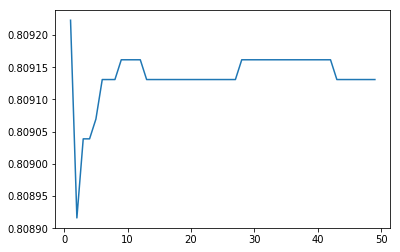

In [58]:
plt.plot(scores_df['lambda'], scores_df['R2_score_log'], label='Log')

## Notes and Conclusions
The primary thing I'm confused about is why the logistic regression model won't fit the data without penalizing it with L1 or L2 regularization. L2 is the default penalty setting. The 'Ridge' and 'Logistic' regression score curvesare the same for different regularization coeffecients.

Are there other models that fit logistic regression with ridge and lasso parameters? Can the log odds (despite the tedious nature of this task) be calculated manually for ridge and lasso regression to then be run on?

Based on the graph, I would choose Lasso as the model of choice simply because it results in a higher R2 score more frequently between lambda = 10 through 20.